# AICrowd - Plant Disease Recognition On Low Resolution Images [Link](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/minileaves)

In this task participants have to correctly identify a disease-class from low-resolution images of plant-leaves. 

## Dataset:
The dataset consists of 43525 images of plant leaves at 32x32 pixels. Each of the images belongs to one of the 38 disease classes (some of these classes also represent healthy leaves). A separate test dataset of 10779 images is provided, and the task is to predict the associated disease (from the 38 valid disease classes) for each of the images. The training and the test set reflect numerous real-world properties of datasets such as class imbalance (some classes have about ~4500 images, while some classes can have as low as ~120 images in the training set) etc. The images for both the training and the test set are aggregated into individual Numpy array files for convenient programmatic access.

## Files:
1. train-images.npy - (43525 samples) A numpy file with an ndarray of shape (43525, 32, 32, 3) representing all the images in the training set.
2. train-labels.npy - (43525 samples) A numpy file with a ndarray of shape (43525,) representing the corresponding labels for the images in the training set. This array consists of a unique index per-class. And a mapping of the index to a human-readable class name can be found in all_classes.txt.
3. test-images.npy - (10779 samples) A numpy file with an ndarray of shape (10779, 32, 32, 3) representing all the images in the test set.
4. all_classes.txt - A file containing the mapping of the class index used in the train-labels.npy file, and the sample_submission.csv file to that of a human-readable class name. The file contains 38 lines, where the line index of the class-name in the file is the index of the class names in all the labels files.
5. sample_submission.csv - A sample submission file to provide a reference about the expected file format for the submission system to work.

## Submission:
Prepare a CSV containing header as class_index and the predicted class index [0-38) with the name as submission.csv. Sample submission format available as sample_submission.csv in the resources section.

## Evaluation:
During evaluation F1 score and Accuracy Score will be used to test the efficiency of the model

## Google Drive Mount and Imports

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.utils import to_categorical
from keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from time import time

## Load data 

In [3]:
with open("/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/all_classes.txt") as f:
    cat_labels = [_[:-1] for _ in f.readlines()]

print(cat_labels)

['apple-apple-scab', 'apple-black-rot', 'apple-cedar-apple-rust', 'apple-healthy', 'blueberry-healthy', 'cherry-including-sour-healthy', 'cherry-including-sour-powdery-mildew', 'corn-maize-cercospora-leaf-spot-gray-leaf-spot', 'corn-maize-common-rust', 'corn-maize-healthy', 'corn-maize-northern-leaf-blight', 'grape-black-rot', 'grape-esca-black-measles', 'grape-healthy', 'grape-leaf-blight-isariopsis-leaf-spot', 'orange-haunglongbing-citrus-greening', 'peach-bacterial-spot', 'peach-healthy', 'pepper-bell-bacterial-spot', 'pepper-bell-healthy', 'potato-early-blight', 'potato-healthy', 'potato-late-blight', 'raspberry-healthy', 'soybean-healthy', 'squash-powdery-mildew', 'strawberry-healthy', 'strawberry-leaf-scorch', 'tomato-bacterial-spot', 'tomato-early-blight', 'tomato-healthy', 'tomato-late-blight', 'tomato-leaf-mold', 'tomato-septoria-leaf-spot', 'tomato-spider-mites-two-spotted-spider-mite', 'tomato-target-spot', 'tomato-tomato-mosaic-virus', 'tomato-tomato-yellow-leaf-curl-viru']

In [4]:
train_images = np.load("/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/train-images.npy")
train_labels = np.load("/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/train-labels.npy")

print(F"Data stats : {train_images.shape}")
print(F"Labels stats : {train_labels.shape}")

Data stats : (43466, 32, 32, 3)
Labels stats : (43466,)


In [0]:
def reshape_fx(X_array):
    assert X_array.shape[1:] == (32, 32, 3) # as the images are of the dimension 32x32x3
    
    # We normalize the whole array to a [0-1] range. As the pixel RGB values are uint8 values in the range[0, 256], 
    # we will normalize simply by dividing the whole array by 255
    X_array = X_array.astype(np.float32) / 255.0
    
    # Now, we will reshape the ndarray of shape (N, 32, 32, 3) to (N, 32*32*3), where N is the number of samples
    # present in the dataset
    X_array = X_array.reshape(X_array.shape[0], 32*32*3)
    return X_array

def reshape_bx(X_array):
    assert X_array.shape[1:]  == (3072,) # as the images are of the dimension 32x32x3
    
    # Now, we will reshape the ndarray of shape (N, 32*32*3) to (N, 32, 32, 3), where N is the number of samples
    # present in the dataset
    X_array = np.reshape(X_array, (X_array.shape[0], 32, 32, 3))
    return X_array

In [0]:
mean = np.mean(train_images)
std = np.std(train_images)
train_images = (train_images-mean)/(std+1e-7)

In [7]:
x_train, x_validation, y_train, y_validation = train_test_split(train_images, train_labels, test_size=0.1, stratify=train_labels)
print(F"Training data stats : {x_train.shape}")
print(F"Validation data stats : {x_validation.shape}")

x_train_transformed, x_validation_transformed = reshape_fx(x_train), reshape_fx(x_validation)
print(F"Transformed training data stats : {x_train_transformed.shape}")
print(F"Transformed validation data stats : {x_validation_transformed.shape}")

Training data stats : (39119, 32, 32, 3)
Validation data stats : (4347, 32, 32, 3)
Transformed training data stats : (39119, 3072)
Transformed validation data stats : (4347, 3072)


## Neural Networks

1. MLP
2. Cifar-10 
3. Custom NN
4. Transfer Learning

In [0]:
num_classes = 38
epochs = 30
batch_size = 32
num_features = 32

width, height, channels = 32, 32, 3

In [0]:
y_train_cat = to_categorical(y_train)
y_validation_cat = to_categorical(y_validation)

### MLP

In [0]:
def mlp_arch():
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(3072,)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [0]:
model = mlp_arch()

history = model.fit(x_train_transformed, y_train_cat, 
                    epochs = epochs,
                    batch_size = 64,
                    validation_data=(x_validation_transformed, y_validation_cat))

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
predictions = model.predict(x_validation_transformed)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation_cat, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation_cat, axis=1))

print(cr_report)

In [0]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale = 0.8) #for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 8})# font si

### Cifar 10 

In [0]:
def cifar_10_arch():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = RMSprop(learning_rate=0.0001, decay=1e-6)

    print(model.summary())

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    
    return model

In [0]:
model = cifar_10_arch()

history = model.fit(x_train, y_train_cat, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_validation, y_validation_cat))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_50 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 64)       

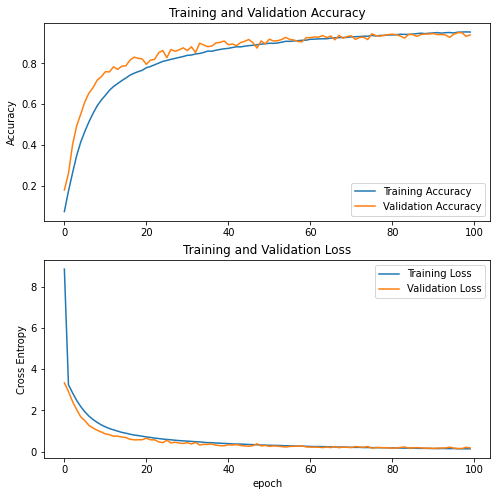

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
predictions = model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation_cat, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation_cat, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84        47
           1       0.94      0.92      0.93        52
           2       0.77      0.74      0.76        23
           3       0.85      0.99      0.92       113
           4       0.99      0.92      0.96       129
           5       0.99      0.96      0.97        69
           6       0.99      0.84      0.91        96
           7       0.78      0.74      0.76        43
           8       0.99      0.98      0.98        97
           9       1.00      0.98      0.99        94
          10       0.89      0.91      0.90        77
          11       0.96      0.89      0.92       102
          12       0.94      0.96      0.95       106
          13       1.00      1.00      1.00        34
          14       0.95      0.99      0.97        83
          15       1.00      0.99      0.99       443
          16       0.96      0.98      0.97       182
          17       0.97    

In [0]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale = 0.8) #for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 8})# font si

### Custom NN

In [0]:
def custom_nn():
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    #Compliling the model with adam optimixer and categorical crossentropy loss
    model.compile(loss="categorical_crossentropy",
                optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                metrics=['accuracy'])
    
    return model

# custom_nn()

In [21]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

model = custom_nn()

lrr= ReduceLROnPlateau(monitor='val_loss', #Metric to be measured
                       factor=.5, #Factor by which learning rate will be reduced
                       patience=10,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-6)

history = model.fit(datagen.flow(x_train, y_train_cat, batch_size = 512),
                    steps_per_epoch=x_train.shape[0] // 512,
                    epochs=150,
                    callbacks=[lrr],
                    shuffle=True,
                    validation_data=(x_validation, y_validation_cat))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 15, 64)       

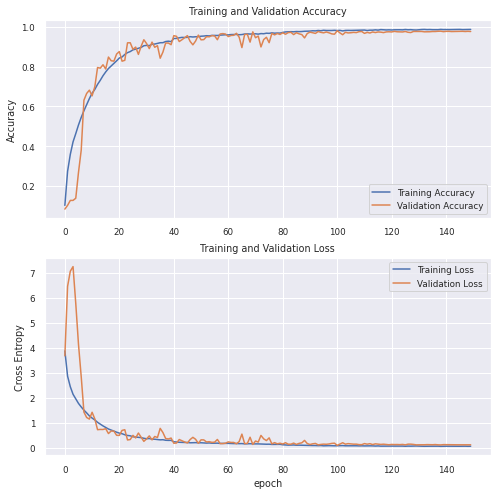

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
predictions = model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation_cat, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation_cat, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        48
           1       0.94      0.96      0.95        50
           2       0.91      1.00      0.95        20
           3       0.89      0.99      0.94       118
           4       1.00      0.97      0.98       124
           5       0.97      0.98      0.98        66
           6       0.98      1.00      0.99        80
           7       0.98      0.85      0.91        47
           8       1.00      1.00      1.00        96
           9       1.00      1.00      1.00        92
          10       0.91      1.00      0.95        72
          11       1.00      0.99      0.99        96
          12       0.99      1.00      1.00       108
          13       1.00      1.00      1.00        34
          14       1.00      1.00      1.00        86
          15       0.98      1.00      0.99       433
          16       0.98      0.98      0.98       186
          17       1.00    

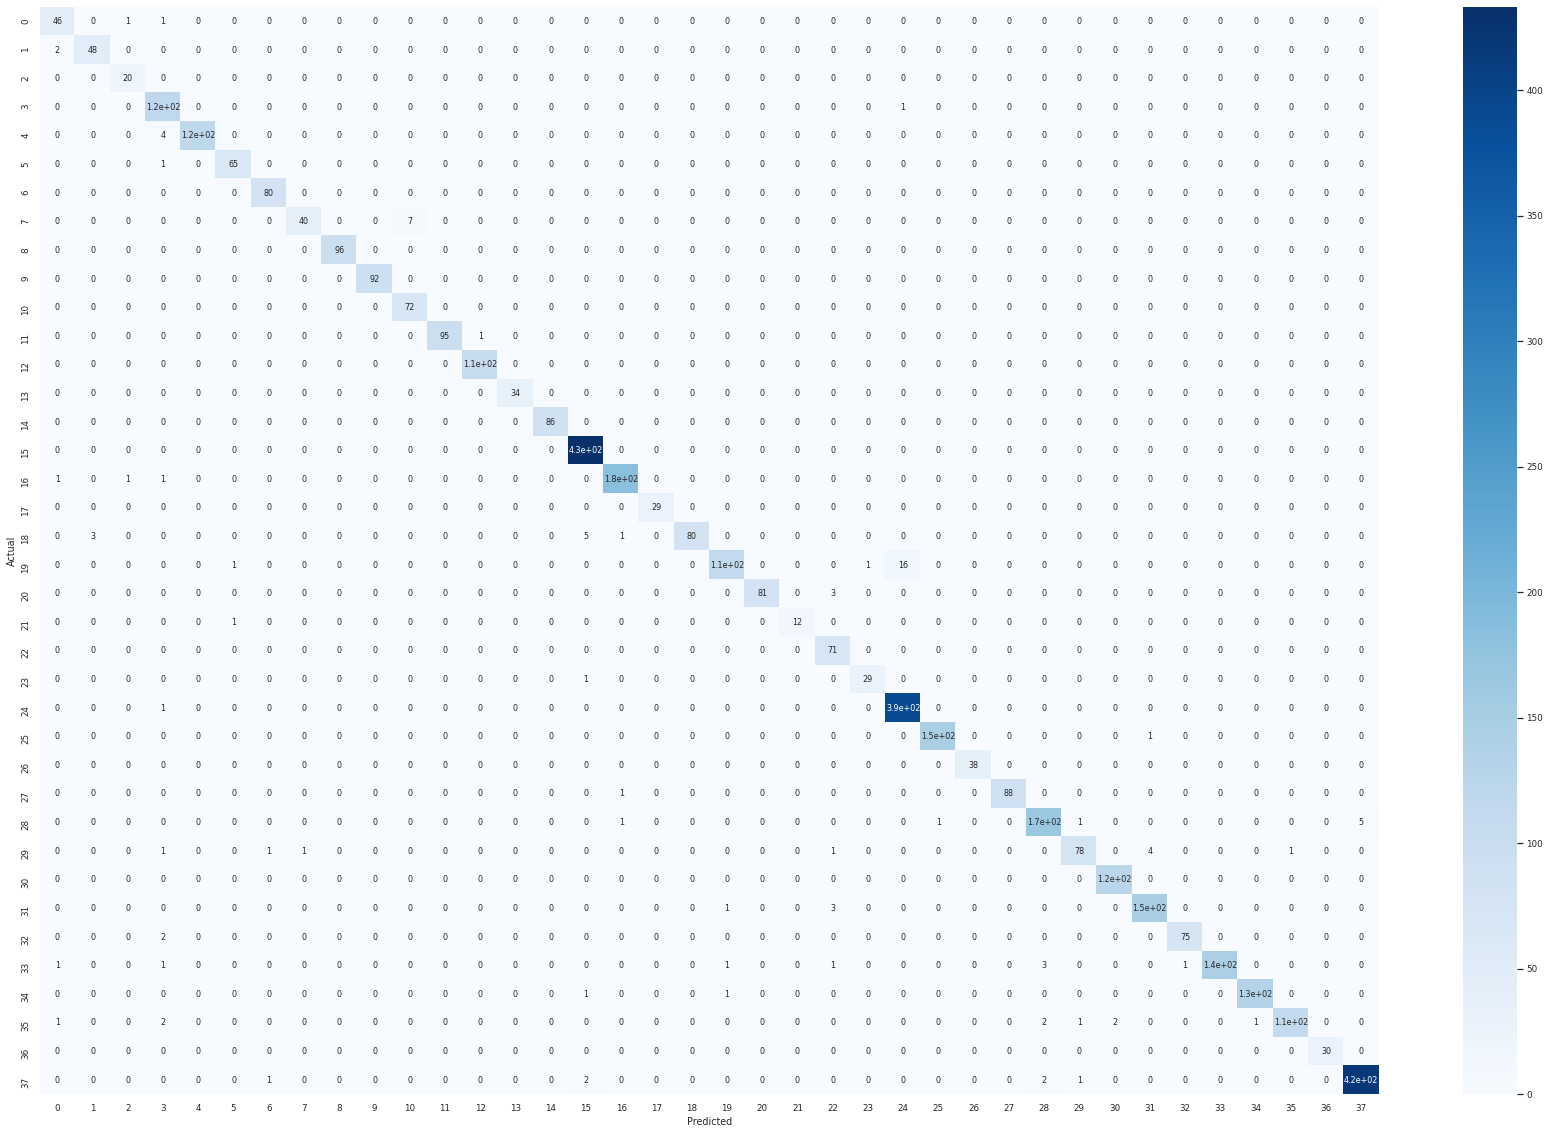

In [24]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale = 0.8) #for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 8})# font si

### Transfer Learning

In [0]:
def vgg16():
    model = Sequential()

    input_tensor = Input(shape=(32, 32, 3))
    base_model = applications.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(base_model)
    model.add(GlobalMaxPool2D())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    model.compile(
        optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
        loss="categorical_crossentropy", 
        metrics=['accuracy']
    )

    return model

def vgg19():
    model = Sequential()

    input_tensor = Input(shape=(32, 32, 3))
    base_model = applications.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    model.compile(
        optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
        loss="categorical_crossentropy", 
        metrics=['accuracy']
    )

    return model

def resnet50v2():
    model = Sequential()

    input_tensor = Input(shape=(32, 32, 3))
    base_model = applications.ResNet50V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

    model.compile(
        optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
        loss="categorical_crossentropy", 
        metrics=['accuracy']
    )

    return model

In [0]:
model = vgg16() # 93, 89, 93
# model = vgg19() 90, 81, 90
# model = resnet50v2() 85, 73, 87

history = model.fit(x_train, y_train_cat, 
                    epochs = 150,
                    batch_size = 512,
                    validation_data=(x_validation, y_validation_cat))

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_7 (Glob (None, 512)               0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)             

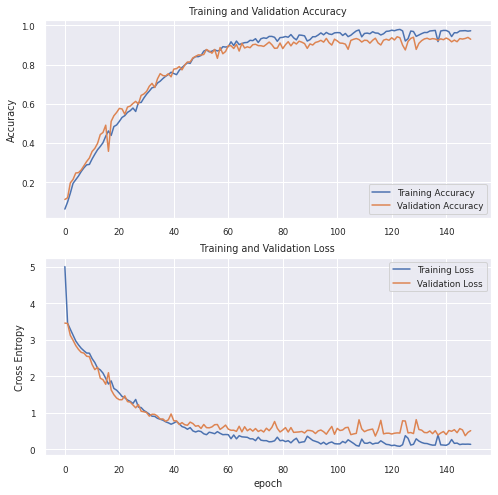

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
predictions = model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation_cat, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation_cat, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.84      0.83      0.83        52
           1       0.78      0.85      0.82        47
           2       0.77      0.44      0.56        39
           3       0.88      0.91      0.89       127
           4       0.93      1.00      0.96       111
           5       0.96      0.97      0.96        66
           6       0.95      0.96      0.96        81
           7       0.83      0.63      0.72        54
           8       0.99      1.00      0.99        95
           9       1.00      1.00      1.00        92
          10       0.73      0.98      0.84        59
          11       0.91      0.89      0.90        97
          12       0.94      0.94      0.94       109
          13       1.00      0.94      0.97        36
          14       0.98      0.98      0.98        86
          15       0.99      1.00      0.99       440
          16       0.97      0.94      0.96       192
          17       0.93    

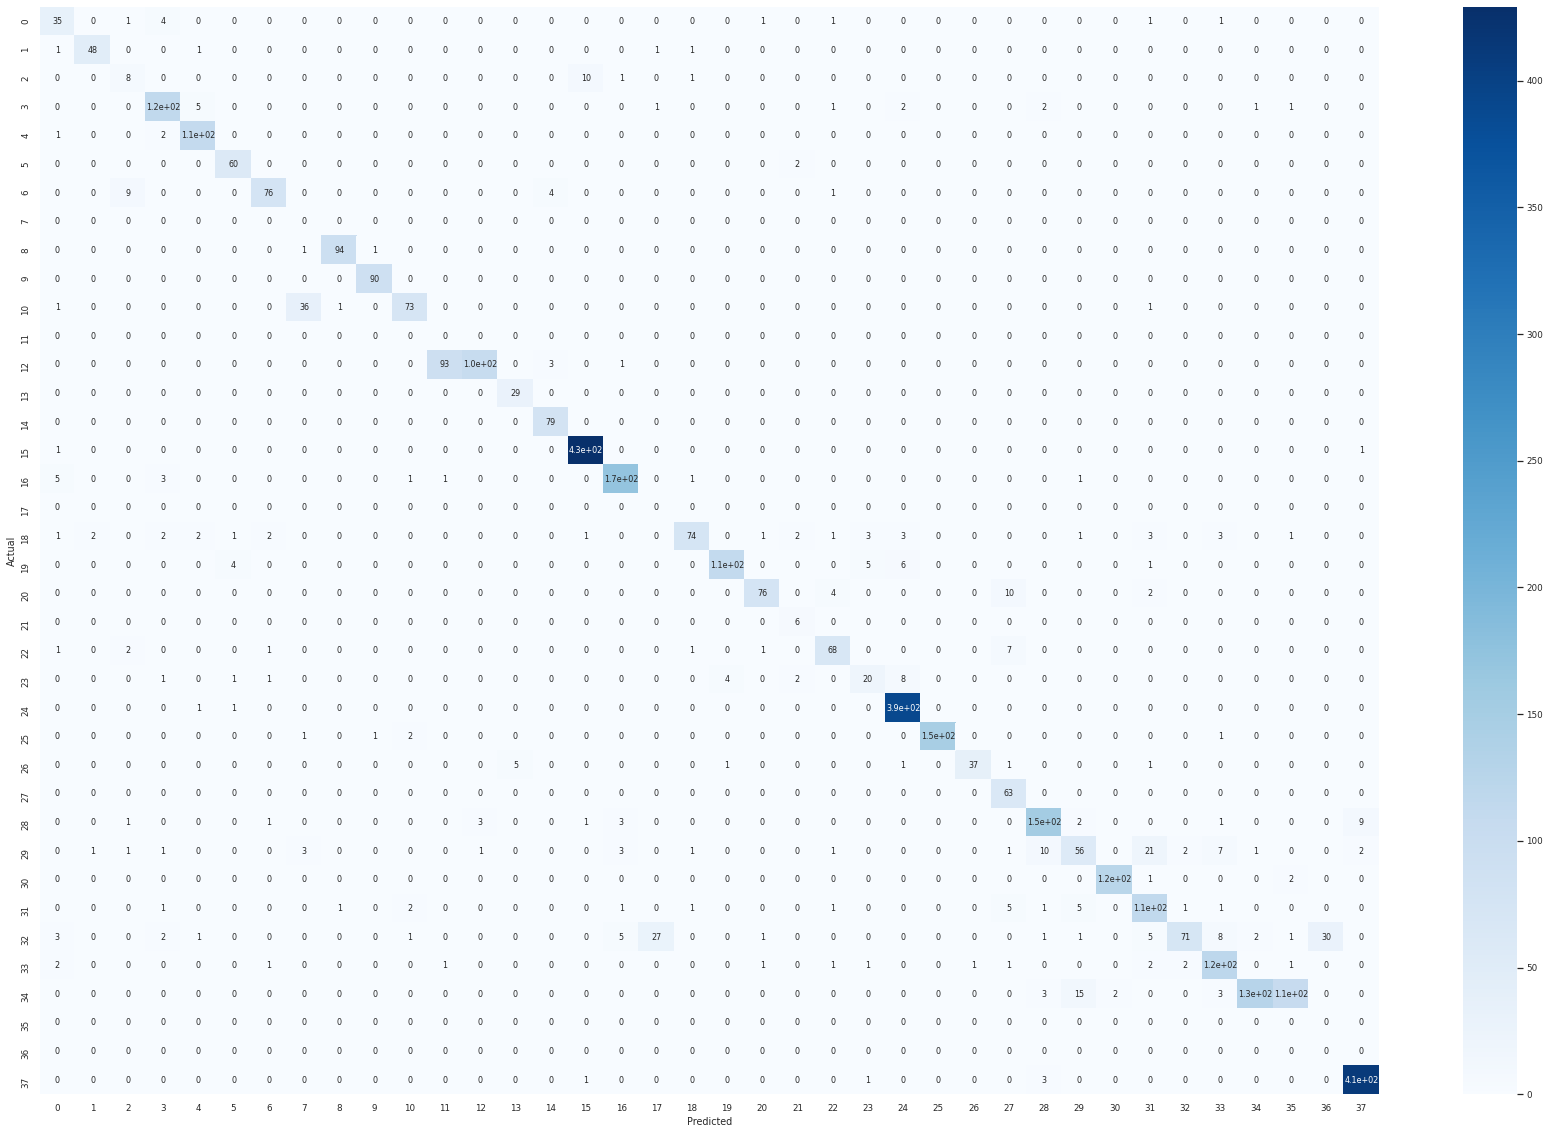

In [0]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale = 0.8) #for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 8})# font si

## Final Output & Submission

In [25]:
test_data = np.load("/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/test-images.npy")
test_data = (test_data-mean)/(std+1e-7)
predictions = model.predict(test_data)
preds = np.argmax(predictions, axis=1)

print(F"Test data stats : {test_data.shape}, {preds.shape}")

pd.DataFrame({"class_index": preds}).to_csv("/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/submission.csv", index=False)

Test data stats : (10838, 32, 32, 3), (10838,)


In [0]:
from google.colab import files
files.download('/gdrive/My Drive/Dataset/AICrowd/MiniLeaves/submission.csv')